Multi-level Perturbed Unit Gradient Descent, MPUGD

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data  import Subset, DataLoader
from sklearn.model_selection  import train_test_split 

import torchvision
import torchvision.transforms as transforms
from types import SimpleNamespace 
import matplotlib.pyplot  as plt
import numpy as np 

from optimizers import *
from upanets import UPANets
from torchsummary import summary
import time, copy,timm
import json
import random 
import os
from train import *

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
args = SimpleNamespace(
    datasets='cifar_10',
    batch_size = 500,
    seed = 42,
    lr=0.1, 
    momentum=0.9,
    wd = 0.0005,
    blocks = 1,
    filters = 16,
    epochs = 40
    )

In [4]:
def set_all_seeds(seed=42):
    # Python原生随机 
    random.seed(seed) 
    # NumPy随机 
    np.random.seed(seed) 
    # PyTorch随机 
    torch.manual_seed(seed) 
    # CUDA随机（GPU相关）
    torch.cuda.manual_seed_all(seed) 
    # CUDNN确定性模式 
    torch.backends.cudnn.deterministic  = True 
    torch.backends.cudnn.benchmark  = False 
 
set_all_seeds(args.seed)  

In [5]:
print(device)

cuda


In [6]:
img_size = 32 # default image size for Cifar-10
im_dimention = 32
cifar_10_mean = [0.4914, 0.4822, 0.4465] 
cifar_10_std = [0.2023, 0.1994, 0.2010]
cifar_100_mean = [0.5071, 0.4867, 0.4408]
cifar_100_std = [0.2673, 0.2564, 0.2762]

if args.datasets == 'cifar_10':
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((im_dimention,im_dimention)),
            transforms.RandomRotation(15,),
            transforms.RandomCrop(im_dimention),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=cifar_10_mean, std=cifar_10_std)
        ]),
        'valid': transforms.Compose([
            transforms.Resize((im_dimention,im_dimention)),
            transforms.ToTensor(),
            transforms.Normalize(mean=cifar_10_mean, std=cifar_10_std)
        ]),
        'test': transforms.Compose([
            transforms.Resize((im_dimention,im_dimention)),
            transforms.ToTensor(),
            transforms.Normalize(mean=cifar_10_mean, std=cifar_10_std)
        ]),
    }
 
    full_trainset = torchvision.datasets.CIFAR10(
        root='./data/cifar_10', train=True, download=True)
    testset = torchvision.datasets.CIFAR10(
        root='./data/cifar_10', train=False, download=True, transform=data_transforms['test'])
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=args.batch_size, shuffle=False, num_workers=0)
    Num_class = 10

if args.datasets == 'cifar_100':
    data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((im_dimention,im_dimention)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(im_dimention),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=cifar_100_mean, std=cifar_100_std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize((im_dimention,im_dimention)),
        transforms.ToTensor(),
        transforms.Normalize(mean=cifar_100_mean, std=cifar_100_std)
    ]),
    'test': transforms.Compose([
        transforms.Resize((im_dimention,im_dimention)),
        transforms.ToTensor(),
        transforms.Normalize(mean=cifar_100_mean, std=cifar_100_std)
    ]),
    }
    full_trainset = torchvision.datasets.CIFAR100(
        root='./data/cifar_100', train=True, download=True)
    testset = torchvision.datasets.CIFAR100(
        root='./data/cifar_100', train=False, download=True, transform=data_transforms['test'])
    testloader = DataLoader(
        testset, batch_size=args.batch_size, shuffle=False,sampler=torch.utils.data.SequentialSampler(testset),  num_workers=0)
    Num_class = 100

# 获取所有样本的标签 
labels = [full_trainset[i][1] for i in range(len(full_trainset))]

# 分层划分（stratify参数确保比例）
train_idx, val_idx = train_test_split(
    range(len(full_trainset)),
    test_size=0.2,
    shuffle=True,
    stratify=labels,
    random_state=args.seed  
)

train_data = np.stack([full_trainset.data[i]  for i in train_idx]) 
train_targets = [full_trainset.targets[i] for i in train_idx] 
val_data = np.stack([full_trainset.data[i]  for i in val_idx]) 
val_targets = [full_trainset.targets[i] for i in val_idx] 


valset = full_trainset
valset.data = val_data
valset.targets = val_targets
valset.transform = data_transforms['valid']

trainset = copy.deepcopy(valset)
trainset.data = train_data
trainset.targets = train_targets
trainset.transform = data_transforms['train']

trainloader = {
    'train':DataLoader(
    trainset, batch_size=args.batch_size, shuffle=False, sampler=torch.utils.data.SequentialSampler(trainset), num_workers=0),
    'valid':DataLoader(
    valset, batch_size=args.batch_size, shuffle=False, sampler=torch.utils.data.SequentialSampler(valset), num_workers=0)}


dataset_sizes = {
    'train': len(trainset),
    'valid': len(valset),            
                 }
print(dataset_sizes)


{'train': 40000, 'valid': 10000}


In [6]:
print(timm.list_models('*vit_tiny_patch16_224*')) 

['vit_tiny_patch16_224']


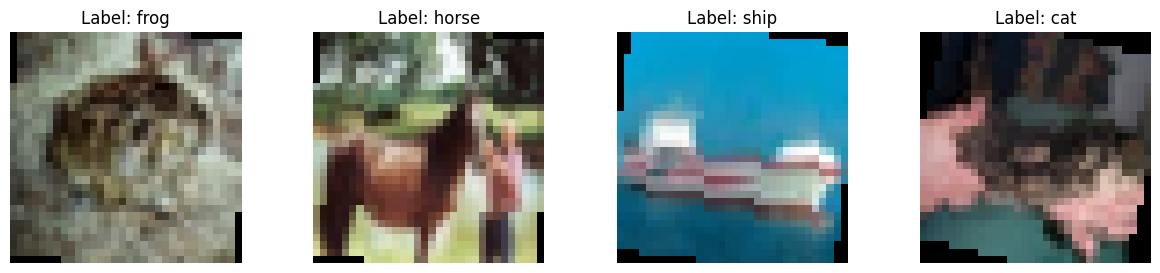

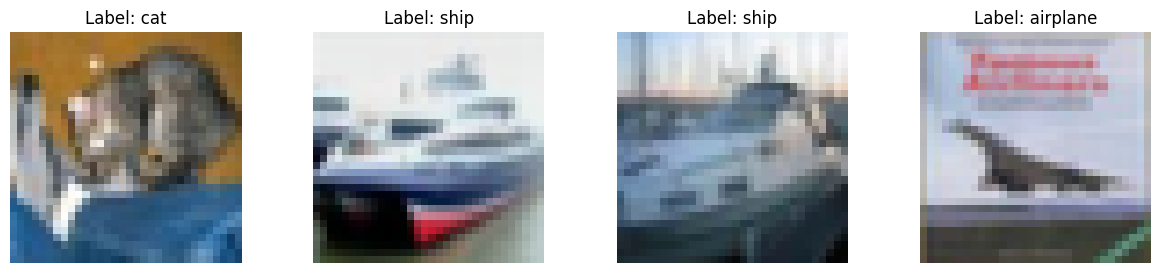

In [7]:
# from torchvision.transforms.functional  import to_pil_image 
# 反归一化转换（需与transform中的参数对应）
inv_normalize = transforms.Normalize(
    mean=[-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010],
    std=[1/0.2023, 1/0.1994, 1/0.2010]
)
 
def show_images(loader, num_images=4):
    # 获取一个batch的数据 
    # images, labels = next(iter(loader))
    for batch_idx, (images, labels) in enumerate(loader):
        if batch_idx == 0:  # 只取第一个batch 
            break 

    # 创建子图 
    fig, axes = plt.subplots(1,  num_images, figsize=(15, 3))
    
    for i in range(num_images):
        # 反归一化+通道顺序调整 
        img = inv_normalize(images[i]).permute(1, 2, 0).numpy()
        img = np.clip(img,  0, 1)  # 处理浮点误差 
        
        # 显示图像及标签 
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {trainset.classes[labels[i]]}") 
        axes[i].axis('off')
    
    plt.show() 
 
show_images(trainloader['train'])
show_images(testloader)

In [7]:
model_path = "./model/benckmark.pth"
if os.path.exists(model_path):
    net_benckmark_data = torch.load(model_path,  map_location='cpu')
    benckmark_state_dict = net_benckmark_data['model_state_dict'] 
else:
    net_benchmark = UPANets(args.filters, Num_class, args.blocks, img_size)
    torch.save({
        'model_state_dict': net_benchmark.state_dict()
    }, model_path)
    benckmark_state_dict = net_benchmark.state_dict()

def tensor_to_serializable(obj):
    if isinstance(obj, torch.Tensor):
        return obj.cpu().numpy().tolist()   # 转CPU→numpy→list 
    return obj 


In [ ]:
net = UPANets(args.filters, Num_class, args.blocks, img_size)
net.load_state_dict(copy.deepcopy(benckmark_state_dict))

criterion = torch.nn.CrossEntropyLoss()

net.to(device)

if device == 'cuda':
    model_ft_org = torch.nn.DataParallel(net)
    # cudnn.benchmark = True

optimizer = optim.SGD(net.parameters(),
                lr=args.lr,
                momentum=args.momentum,
                weight_decay=args.wd,
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

net, metrics_org = train_model_org(net, criterion, optimizer, scheduler, args.epochs * 2, trainloader, device, dataset_sizes) 

# 保存模型架构+参数+优化器状态（完整恢复训练）
model_path = "./model/org" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/cifar10/org_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metrics_org, f, default=tensor_to_serializable, ensure_ascii=False, indent=4)
 
# 加载 

# checkpoint = torch.load('full_model_checkpoint.pth',  map_location='cpu')  # 先加载到CPU避免设备冲突 
# 模型结构需提前定义（需与保存时一致）
# model = YourModelClass()  
# model.load_state_dict(checkpoint['model_state_dict']) 
 
# # 恢复优化器和训练状态 
# optimizer = torch.optim.Adam(model.parameters())  
# optimizer.load_state_dict(checkpoint['optimizer_state_dict']) 
# with open('data.json',  'r', encoding='utf-8') as f:
#     loaded_dict = json.load(f) 


# summary(net, (3, img_size, img_size))


Epoch 0/239
Epoch 1/239
Epoch 2/239
Epoch 3/239
Epoch 4/239
Epoch 5/239
Epoch 6/239
Epoch 7/239
Epoch 8/239
Epoch 9/239
Epoch 10/239
Epoch 11/239
Epoch 12/239
Epoch 13/239
Epoch 14/239
Epoch 15/239
Epoch 16/239
Epoch 17/239
Epoch 18/239
Epoch 19/239
Epoch 20/239
Epoch 21/239
Epoch 22/239
Epoch 23/239
Epoch 24/239
Epoch 25/239
Epoch 26/239
Epoch 27/239
Epoch 28/239
Epoch 29/239
Epoch 30/239
Epoch 31/239
Epoch 32/239
Epoch 33/239
Epoch 34/239
Epoch 35/239
Epoch 36/239
Epoch 37/239
Epoch 38/239
Epoch 39/239
Epoch 40/239
Epoch 41/239
Epoch 42/239
Epoch 43/239
Epoch 44/239
Epoch 45/239
Epoch 46/239
Epoch 47/239
Epoch 48/239
Epoch 49/239
Epoch 50/239
Epoch 51/239
Epoch 52/239
Epoch 53/239
Epoch 54/239
Epoch 55/239
Epoch 56/239
Epoch 57/239
Epoch 58/239
Epoch 59/239
Epoch 60/239
Epoch 61/239
Epoch 62/239
Epoch 63/239
Epoch 64/239
Epoch 65/239
Epoch 66/239
Epoch 67/239
Epoch 68/239
Epoch 69/239
Epoch 70/239
Epoch 71/239
Epoch 72/239
Epoch 73/239
Epoch 74/239
Epoch 75/239
Epoch 76/239
Epoch 77/

In [10]:
# import gc 
 
# gc.collect()           # 触发垃圾回收 
# torch.cuda.empty_cache()   # 再清空PyTorch缓存 

In [19]:
net_pugd = UPANets(args.filters, Num_class, args.blocks, img_size)  
net_pugd.load_state_dict(copy.deepcopy(benckmark_state_dict))
criterion = torch.nn.CrossEntropyLoss()

net_pugd.to(device)

if device == 'cuda':
    model_ft_org = torch.nn.DataParallel(net_pugd)
    # cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDX(net_pugd.parameters(),
                base_optimizer,
                step_x = 0,
                lr=args.lr,
                momentum=args.momentum,
                weight_decay=args.wd,
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

net_pugd, metrics0 = train_model(net_pugd, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

model_path = "./model/pugd" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net_pugd.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/cifar10/pugd_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metrics0,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/39


d:\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 1/39
Epoch 2/39
Epoch 3/39
Epoch 4/39
Epoch 5/39
Epoch 6/39
Epoch 7/39
Epoch 8/39
Epoch 9/39
Epoch 10/39
Epoch 11/39
Epoch 12/39
Epoch 13/39
Epoch 14/39
Epoch 15/39
Epoch 16/39
Epoch 17/39
Epoch 18/39
Epoch 19/39
Epoch 20/39
Epoch 21/39
Epoch 22/39
Epoch 23/39
Epoch 24/39
Epoch 25/39
Epoch 26/39
Epoch 27/39
Epoch 28/39
Epoch 29/39
Epoch 30/39
Epoch 31/39
Epoch 32/39
Epoch 33/39
Epoch 34/39
Epoch 35/39
Epoch 36/39
Epoch 37/39
Epoch 38/39
Epoch 39/39
Training complete in 139m 36s
Best val Acc: 0.899500


In [18]:
import optimizers
import train
import importlib 
importlib.reload(optimizers)   
from optimizers import *
from train import *

In [ ]:
net_pugda = UPANets(args.filters, Num_class, args.blocks, img_size)  
net_pugda.load_state_dict(copy.deepcopy(benckmark_state_dict))
criterion = torch.nn.CrossEntropyLoss()

net_pugda.to(device)

if device == 'cuda':
    model_ft_org = torch.nn.DataParallel(net_pugda)
    # cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDXA(net_pugda.parameters(),
                base_optimizer,
                step_x = 0,
                lr=args.lr,
                momentum=args.momentum,
                weight_decay=args.wd,
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

net_pugda, metricsa = train_model(net_pugda, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

model_path = "./model/pugda" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net_pugda.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/cifar10/pugda_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metricsa,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


Epoch 0/39


d:\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 1/39
Epoch 2/39
Epoch 3/39
Epoch 4/39
Epoch 5/39
Epoch 6/39
Epoch 7/39
Epoch 8/39
Epoch 9/39
Epoch 10/39
Epoch 11/39
Epoch 12/39
Epoch 13/39
Epoch 14/39
Epoch 15/39
Epoch 16/39
Epoch 17/39
Epoch 18/39
Epoch 19/39
Epoch 20/39
Epoch 21/39
Epoch 22/39
Epoch 23/39
Epoch 24/39
Epoch 25/39
Epoch 26/39
Epoch 27/39
Epoch 28/39
Epoch 29/39
Epoch 30/39
Epoch 31/39
Epoch 32/39
Epoch 33/39
Epoch 34/39
Epoch 35/39
Epoch 36/39
Epoch 37/39
Epoch 38/39
Epoch 39/39
Training complete in 136m 1s
Best val Acc: 0.811700


In [20]:
net_pugdcos = UPANets(args.filters, Num_class, args.blocks, img_size)  
net_pugdcos.load_state_dict(copy.deepcopy(benckmark_state_dict))
criterion = torch.nn.CrossEntropyLoss()

net_pugdcos.to(device)

if device == 'cuda':
    model_ft_org = torch.nn.DataParallel(net_pugdcos)
    # cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDXCOS(net_pugdcos.parameters(),
                base_optimizer,
                step_x = 0,
                lr=args.lr,
                max_epochs= args.epochs,
                momentum=args.momentum,
                weight_decay=args.wd,
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

net_pugdcos, metricscos = train_model_alpha(net_pugdcos, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

model_path = "./model/pugdcos" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net_pugdcos.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/cifar10/pugdcos_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metricscos,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)


NameError: name 'train_model_alpha' is not defined

In [ ]:
net_pugdsin = UPANets(args.filters, Num_class, args.blocks, img_size)  
net_pugdsin.load_state_dict(copy.deepcopy(benckmark_state_dict))
criterion = torch.nn.CrossEntropyLoss()

net_pugdsin.to(device)

if device == 'cuda':
    model_ft_org = torch.nn.DataParallel(net_pugdsin)
    # cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDXSIN(net_pugdsin.parameters(),
                base_optimizer,
                step_x = 0,
                lr=args.lr,
                max_epochs= args.epochs,
                momentum=args.momentum,
                weight_decay=args.wd,
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

net_pugdsin, metricscos = train_model_alpha(net_pugdsin, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

model_path = "./model/pugdsin" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net_pugdsin.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/cifar10/pugdsin_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metricscos,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)



# summary(net_pugd, (3, img_size, img_size))


In [ ]:
net_samx1 = UPANets(args.filters, Num_class, args.blocks, img_size)  
net_samx1.load_state_dict(copy.deepcopy(benckmark_state_dict))
criterion = torch.nn.CrossEntropyLoss()

net_samx1.to(device)

if device == 'cuda':
    model_ft_org = torch.nn.DataParallel(net_samx1)
    # cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = SAMX(net_samx1.parameters(),
                base_optimizer,
                step_x = 1,
                lr=args.lr,
                momentum=args.momentum,
                weight_decay=args.wd,
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

net_samx1, metrics_samx1 = train_modelx(net_samx1, criterion, optimizer, scheduler, args.epochs, trainloader, device, dataset_sizes) 

model_path = "./model/samx1" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net_samx1.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/cifar10/samx1_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metrics_samx1,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)



In [ ]:
net_pugdxe1 = UPANets(args.filters, Num_class, args.blocks, img_size)  
net_pugdxe1.load_state_dict(copy.deepcopy(benckmark_state_dict))
criterion = torch.nn.CrossEntropyLoss()

net_pugdxe1.to(device)

if device == 'cuda':
    model_ft_org = torch.nn.DataParallel(net_pugdxe1)
    # cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDX(net_pugdxe1.parameters(),
                base_optimizer,
                step_x = 1,
                lr=args.lr,
                momentum=args.momentum,
                weight_decay=args.wd,
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                )


scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

net_pugdxe1, metrics = train_modelx(net_pugdxe1, criterion, optimizer, scheduler, int(args.epochs/3*2), trainloader, device, dataset_sizes) 

model_path = "./model/pugdx1" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net_pugdxe1.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/cifar10/pugdx1_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metrics,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)

# summary(net_pugdxe1, (3, img_size, img_size))


Epoch 0/79


d:\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 1/79
Epoch 2/79
Epoch 3/79
Epoch 4/79
Epoch 5/79
Epoch 6/79
Epoch 7/79
Epoch 8/79
Epoch 9/79
Epoch 10/79
Epoch 11/79
Epoch 12/79
Epoch 13/79
Epoch 14/79
Epoch 15/79
Epoch 16/79
Epoch 17/79
Epoch 18/79
Epoch 19/79
Epoch 20/79
Epoch 21/79
Epoch 22/79
Epoch 23/79
Epoch 24/79
Epoch 25/79
Epoch 26/79
Epoch 27/79
Epoch 28/79
Epoch 29/79
Epoch 30/79
Epoch 31/79
Epoch 32/79
Epoch 33/79
Epoch 34/79
Epoch 35/79
Epoch 36/79
Epoch 37/79
Epoch 38/79
Epoch 39/79
Epoch 40/79
Epoch 41/79
Epoch 42/79
Epoch 43/79
Epoch 44/79
Epoch 45/79
Epoch 46/79
Epoch 47/79
Epoch 48/79
Epoch 49/79
Epoch 50/79
Epoch 51/79
Epoch 52/79
Epoch 53/79
Epoch 54/79
Epoch 55/79
Epoch 56/79
Epoch 57/79
Epoch 58/79
Epoch 59/79
Epoch 60/79
Epoch 61/79
Epoch 62/79
Epoch 63/79
Epoch 64/79
Epoch 65/79
Epoch 66/79
Epoch 67/79
Epoch 68/79
Epoch 69/79
Epoch 70/79
Epoch 71/79
Epoch 72/79
Epoch 73/79
Epoch 74/79
Epoch 75/79
Epoch 76/79
Epoch 77/79
Epoch 78/79
Epoch 79/79
Training complete in 371m 46s
Best val Acc: 0.910200


NameError: name 'tensor_to_serializable' is not defined

In [ ]:
import train
import importlib 
importlib.reload(train)   
from train import *

In [ ]:
net_pugdxe_last = UPANets(args.filters, Num_class, args.blocks, img_size)  
net_pugdxe_last.load_state_dict(copy.deepcopy(benckmark_state_dict))
criterion = torch.nn.CrossEntropyLoss()

net_pugdxe_last.to(device)

net_pugdxe_last.linear.weight.last = True
net_pugdxe_last.linear.bias.last = True

if device == 'cuda':
    model_ft_org = torch.nn.DataParallel(net_pugdxe_last)
    # cudnn.benchmark = True

base_optimizer = optim.SGD
optimizer = PUGDX(net_pugdxe_last.parameters(),
                base_optimizer,
                step_x = 1,
                lr=args.lr,
                momentum=args.momentum,
                weight_decay=args.wd,
                dampening=0,   # 必须设置为0才能完全固定 
                nesterov=False # 禁用Nesterov动量 
                )


scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

net_pugdxe_last, metrics_last = train_modelx_last(net_pugdxe_last, criterion, optimizer, scheduler, int(args.epochs/3*2), trainloader, device, dataset_sizes) 


model_path = "./model/pugdx0_last" + str(args.epochs) + ".pth"
torch.save({
    'model_state_dict': net_pugdxe_last.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict()
}, model_path) 

name = "./results/cifar10/pugdx0_last_" + str(args.epochs) + ".json"
with open(name,  'w', encoding='utf-8') as f:
    json.dump(metrics_last,  f, default=tensor_to_serializable, ensure_ascii=False, indent=4)

# summary(net_pugdxe_last, (3, img_size, img_size))

Epoch 0/39


d:\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train Loss: 202589793781.7704 Acc: 0.0994
valid Loss: 91785266626.5600 Acc: 0.1000
Epoch 1/39
train Loss: 170170167296.0000 Acc: 0.0973
valid Loss: 44713276702.7200 Acc: 0.1000
Epoch 2/39
train Loss: 143684505395.2000 Acc: 0.1000
valid Loss: 108533761228.8000 Acc: 0.1000
Epoch 3/39
train Loss: 146182945525.7600 Acc: 0.1006
valid Loss: 44984668119.0400 Acc: 0.1000
Epoch 4/39
train Loss: 130193943203.8400 Acc: 0.1004
valid Loss: 72261932400.6400 Acc: 0.1000
Epoch 5/39
train Loss: 109774753771.5200 Acc: 0.0984
valid Loss: 65628524748.8000 Acc: 0.1000
Epoch 6/39
train Loss: 98075327232.0000 Acc: 0.0989
valid Loss: 66362740162.5600 Acc: 0.1000
Epoch 7/39
train Loss: 89249726924.8000 Acc: 0.0982
valid Loss: 56964185989.1200 Acc: 0.1000
Epoch 8/39
train Loss: 73436323174.4000 Acc: 0.0984
valid Loss: 32794269757.4400 Acc: 0.1000
Epoch 9/39
train Loss: 63230114867.2000 Acc: 0.0999
valid Loss: 37460583751.6800 Acc: 0.1000
Epoch 10/39
train Loss: 54828450298.8800 Acc: 0.0983
valid Loss: 336367198

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.animation  import FuncAnimation 

In [ ]:
x = np.linspace(-5,  5, 100)
y = np.linspace(-3,  3, 100)
X, Y = np.meshgrid(x,  y)

In [ ]:
%matplotlib widget 

In [ ]:
import matplotlib 
print("当前后端:", matplotlib.get_backend())   # 应显示module://ipympl.backend_nbagg  

当前后端: widget


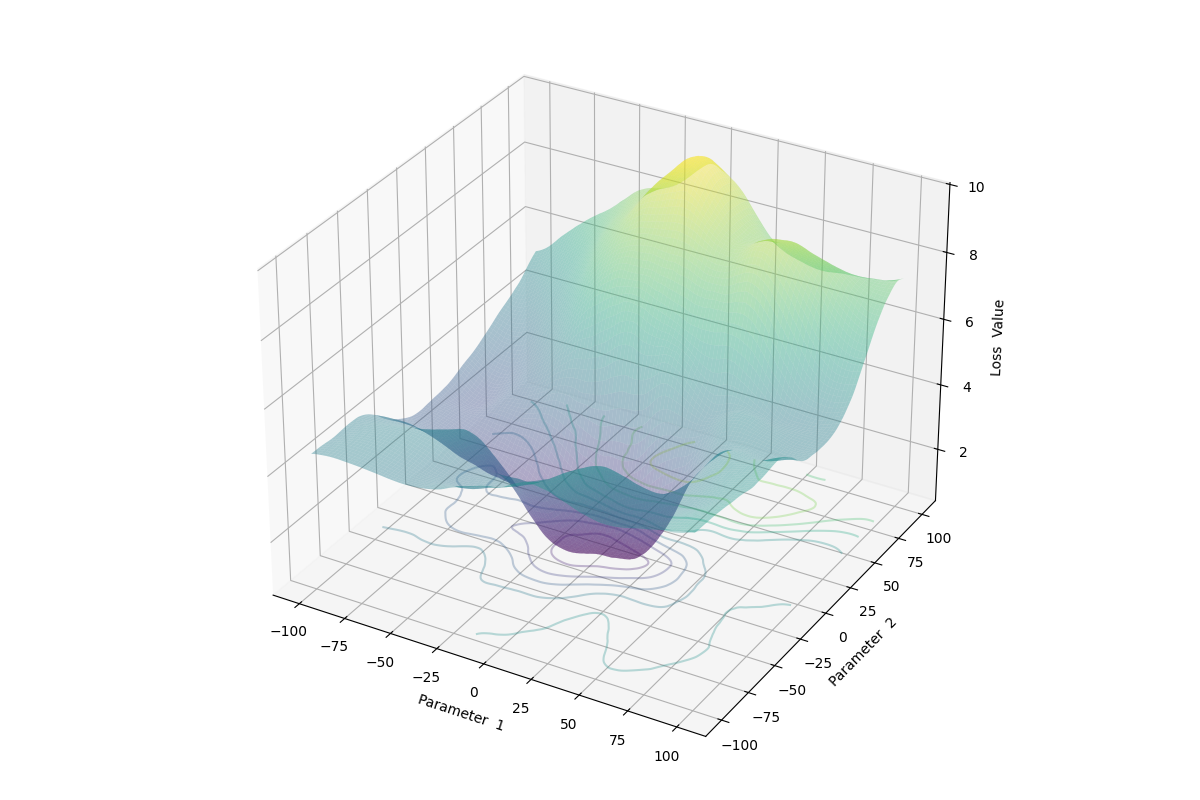

In [ ]:
first_batch = next(iter(testloader))
img = first_batch[0][:8].to(device)
label = first_batch[1][:8].to(device)

x_cord_min = -100
y_cord_min = -100
x_cord_max = 100
y_cord_max = 100
x_split_num = 201
y_split_num = 201
weight_perturbation_scale = 0.01
x_step = (x_cord_max - x_cord_min)/(x_split_num-1)
y_step = (y_cord_max - y_cord_min)/(y_split_num-1)

x = np.linspace(x_cord_min, x_cord_max, x_split_num)
y = np.linspace(y_cord_min, y_cord_max, y_split_num)
X, Y = np.meshgrid(x,  y)
Z = np.zeros((len(y),len(x))) 

model = net
initial_weights = [p.data.clone() for p in model.parameters() if p.requires_grad]
trainable_idx = [i for i, p in enumerate(model.parameters())  if p.requires_grad] 

@torch.no_grad()
def get_model_directions(model:nn.Module):
    dirs = torch.stack([
                (pa/pa.norm(p=2))
                for pa in model.parameters()
                  if pa.requires_grad
                ])
    return dirs

@torch.no_grad()
def get_random_directions(model:nn.Module):
    random_dirs = [torch.randn(w.size()).to(w) for w in model.parameters() if w.requires_grad]
    rd_norms = [rd/rd.norm(p=2) for rd in random_dirs]
    return rd_norms

def perturbate_weights(model, weights, trainable_idx, x_dir, y_dir, x_step, y_step, scale):
    changes = [dx*x_step + dy*y_step for (dx, dy) in zip(x_dir, y_dir)]
    parameters = list(model.parameters())
    for i in trainable_idx:
        parameters[i].data  = weights[i] + scale * changes[i].to(weights[i])


def calculate_perturbation_loss(model, weights, trainable_idx, x_dir, y_dir, x_step, y_step, scale, x, y, Z, imgs, labels, criterion):
    for i in range(len(y)):
        for j in range(len(x)):
            perturbate_weights(model, weights, trainable_idx, x_dir, y_dir, x_step * x[j], y_step * y[i], scale)
            with torch.no_grad():
                outputs = model(imgs)
                # _, preds = torch.max(outputs, 1)
                Z[i][j] = criterion(outputs, labels)

x_dir = get_random_directions(model)
y_dir = get_random_directions(model)
calculate_perturbation_loss(model, initial_weights, trainable_idx, x_dir, y_dir, x_step, y_step, weight_perturbation_scale, x, y, Z, img, label, criterion)

fig = plt.figure(figsize=(12,  8))
ax = fig.add_subplot(111,  projection='3d')

# 绘制半透明损失曲面 
surf = ax.plot_surface(X,  Y, Z, cmap='viridis', 
                        alpha=0.4, antialiased=True,
                        rstride=2, cstride=2)

# 添加等高线投影 
ax.contour(X,  Y, Z, 10, zdir='z', offset=Z.min(),  
            cmap='viridis', alpha=0.3)


ax.set_xlabel('Parameter  1')
ax.set_ylabel('Parameter  2')
ax.set_zlabel('Loss  Value')
plt.tight_layout()
     

interactive(children=(IntSlider(value=30, description='elev', max=90, step=5), IntSlider(value=45, description…

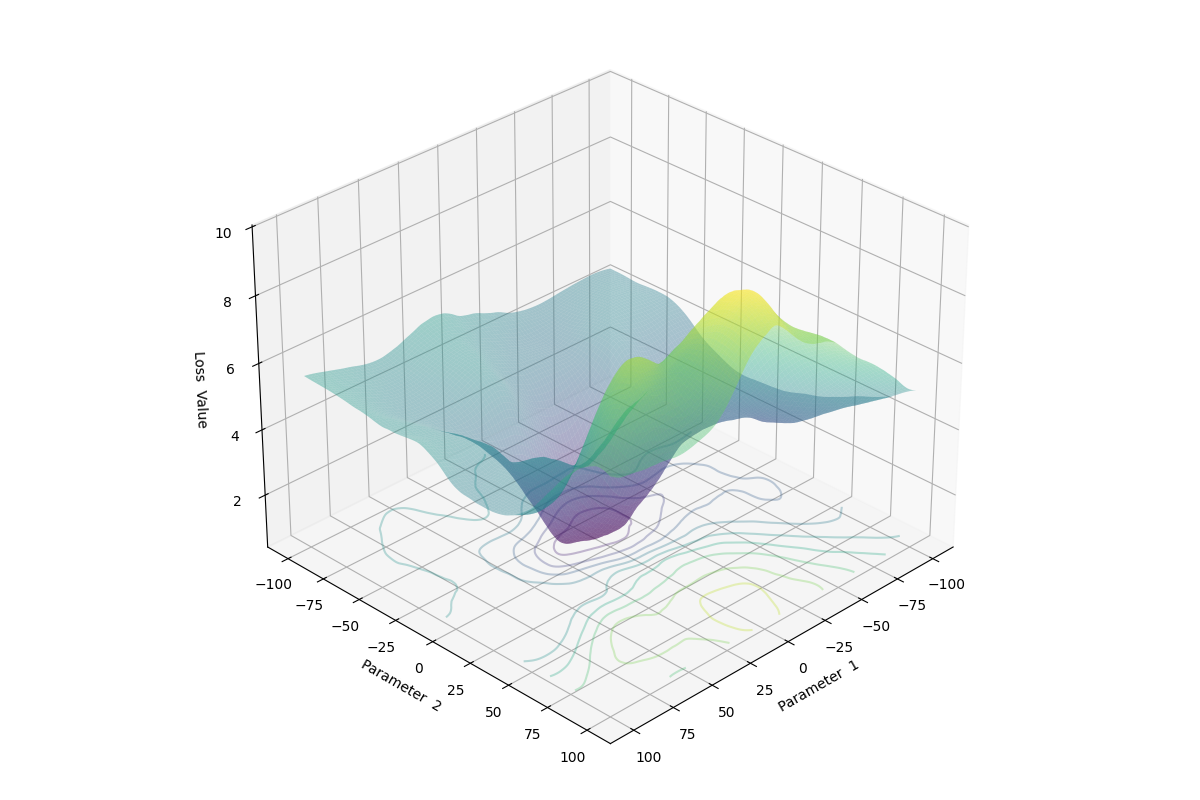

In [ ]:
from ipywidgets import interact
 
# Cell 3: 交互控制（单独Cell执行）
@interact(elev=(0,90,5),  azim=(0,360,5))
def update(elev=30, azim=45):
    ax.view_init(elev,  azim)
    fig.canvas.draw()
    
display(fig.canvas)

C:\Users\eeyzs1\AppData\Local\Temp\ipykernel_16372\1650411430.py:24: RuntimeWarning: overflow encountered in scalar power
  grad_x = -2*(1-current_pos[0]) - 400*current_pos[0]*(current_pos[1]-current_pos[0]**2)
C:\Users\eeyzs1\AppData\Local\Temp\ipykernel_16372\1650411430.py:25: RuntimeWarning: overflow encountered in scalar power
  grad_y = 10*(current_pos[1] - current_pos[0]**2)
C:\Users\eeyzs1\AppData\Local\Temp\ipykernel_16372\1650411430.py:24: RuntimeWarning: invalid value encountered in scalar subtract
  grad_x = -2*(1-current_pos[0]) - 400*current_pos[0]*(current_pos[1]-current_pos[0]**2)
C:\Users\eeyzs1\AppData\Local\Temp\ipykernel_16372\1650411430.py:25: RuntimeWarning: invalid value encountered in scalar subtract
  grad_y = 10*(current_pos[1] - current_pos[0]**2)


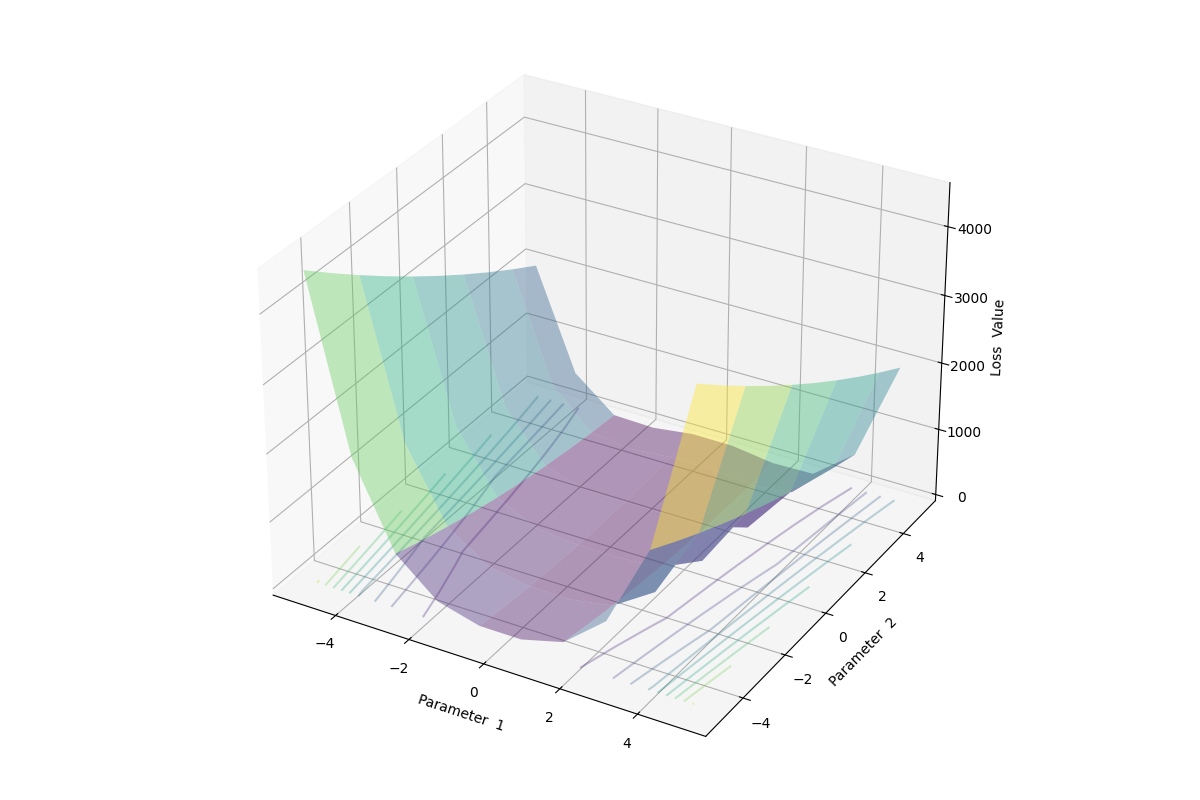

In [ ]:
import numpy as np 
import matplotlib.pyplot  as plt 
from mpl_toolkits.mplot3d  import Axes3D 
from matplotlib.animation  import FuncAnimation 
from matplotlib.colors  import ListedColormap 
import torch 
 
# ========== 1. 模拟优化过程 ==========
def simulate_optimization():
    """生成模拟优化轨迹和损失历史"""
    # 创建虚拟参数空间网格 
    x = np.linspace(-5,  5, 10)
    y = np.linspace(-5,  5, 10)
    X, Y = np.meshgrid(x,  y)
    
    # 定义损失曲面 (Rosenbrock函数)
    Z = (1 - X)**2 + 5 * (Y - X**2)**2 
    
    # 模拟优化轨迹 (SGD路径)
    trajectory = []
    current_pos = np.array([-4.0,  3.0])
    lr = 0.01 
    for step in range(10):
        grad_x = -2*(1-current_pos[0]) - 400*current_pos[0]*(current_pos[1]-current_pos[0]**2)
        grad_y = 10*(current_pos[1] - current_pos[0]**2)
        current_pos -= lr * np.array([grad_x,  grad_y])
        trajectory.append(current_pos.copy()) 
    
    return X, Y, Z, np.array(trajectory) 
 
# ========== 2. 创建3D透明环境 ==========
def create_3d_environment(X, Y, Z, trajectory):
    fig = plt.figure(figsize=(12,  8))
    ax = fig.add_subplot(111,  projection='3d')
    
    # 绘制半透明损失曲面 
    surf = ax.plot_surface(X,  Y, Z, cmap='viridis', 
                         alpha=0.4, antialiased=True,
                         rstride=2, cstride=2)
    
    # 添加等高线投影 
    ax.contour(X,  Y, Z, 10, zdir='z', offset=Z.min(),  
              cmap='viridis', alpha=0.3)
    
    # 初始化轨迹线 
    line, = ax.plot([],  [], [], 'r-', lw=2)
    point, = ax.plot([],  [], [], 'ro', markersize=8)
    
    # 动态更新函数 
    def update(frame):
        # 更新轨迹线 
        line.set_data(trajectory[:frame,  0], trajectory[:frame, 1])
        line.set_3d_properties(Z.min()) 
        
        # 更新当前位置点 
        x, y = trajectory[frame]
        z = (1 - x)**2 + 100 * (y - x**2)**2 
        point.set_data([x],  [y])
        point.set_3d_properties([z]) 
        
        # 动态调整视角 
        ax.view_init(elev=30,  azim=frame/2)
        
        # 透明度渐变效果 
        surf.set_alpha(0.2  + 0.6 * (1 - frame/10))
        
        return line, point, surf 
    
    # 创建动画 
    # ani = FuncAnimation(fig, update, frames=len(trajectory), interval=50, blit=True)
    
    ax.set_xlabel('Parameter  1')
    ax.set_ylabel('Parameter  2')
    ax.set_zlabel('Loss  Value')
    plt.tight_layout() 
    return fig, ax

X, Y, Z, trajectory = simulate_optimization()
fig, ax = create_3d_environment(X, Y, Z, trajectory)

# 保存为GIF（需安装pillow）
# ani.save('3d_optimization.gif',  writer='pillow', fps=20, dpi=150)

# 或直接显示 
plt.show() 

interactive(children=(IntSlider(value=30, description='elev', max=90, step=5), IntSlider(value=45, description…

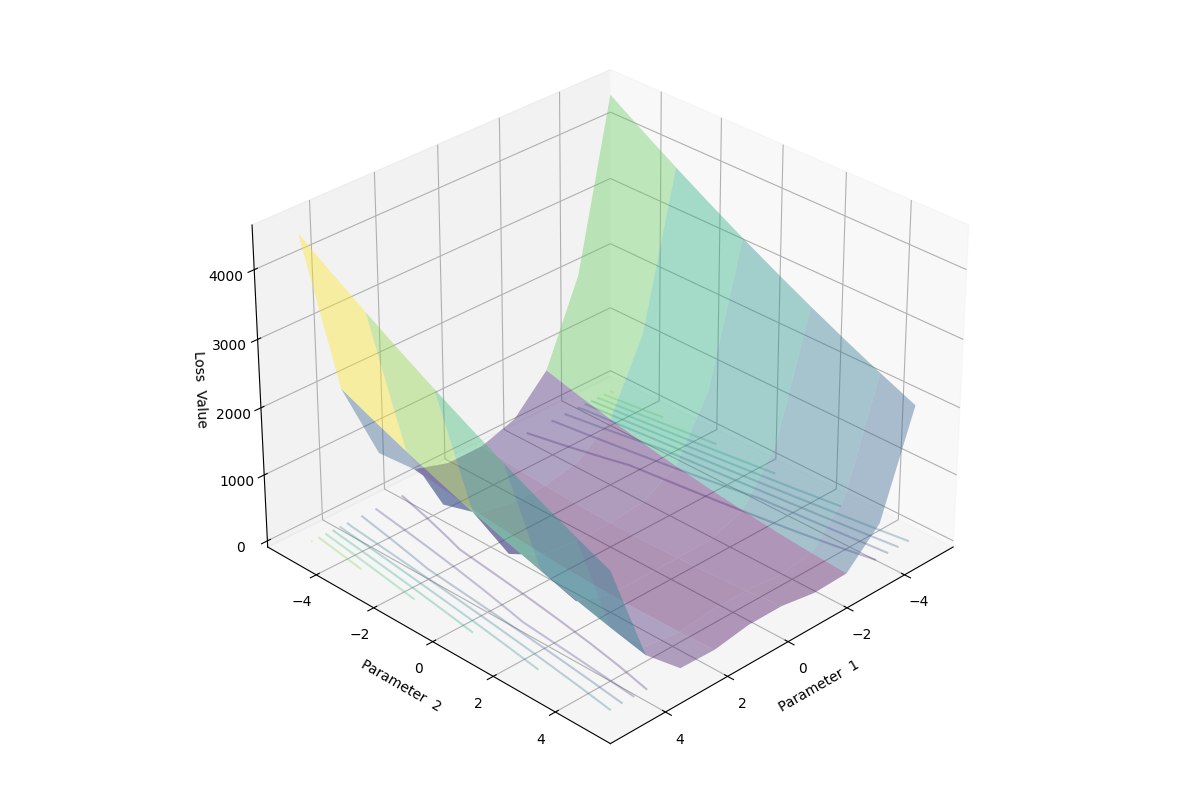

In [ ]:
from ipywidgets import interact
 
# Cell 3: 交互控制（单独Cell执行）
@interact(elev=(0,90,5),  azim=(0,360,5))
def update(elev=30, azim=45):
    ax.view_init(elev,  azim)
    fig.canvas.draw()
    
display(fig.canvas)

In [ ]:
# print(new_head.__dict__)
# print(vars(new_head))
# import optimizers
# import importlib 
# importlib.reload(optimizers)   
# from optimizers import *

In [ ]:
# model_ft2 = timm.create_model('mobilenetv3_small_100', pretrained=True, num_classes=Num_class)
# original_head = model_ft2.classifier   # MobileNetV3的分类头名为classifier 
# new_head = nn.Linear(original_head.in_features,  Num_class)
# model_ft2 = model_ft2.to(device)
# criterion = torch.nn.CrossEntropyLoss()


# base_optimizer2 = optim.SGD
# optimizer2 = PUGD2(model_ft2.parameters(),
#                  base_optimizer2,
#                  lr=args.lr,
#                  momentum=args.momentum,
#                  weight_decay=args.wd,
#                  )


# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=7, gamma=0.1)

# model_ft2 = train_model2(model_ft2, criterion, optimizer2, exp_lr_scheduler, num_epochs=20) 